# SmolVLM Streaming Inference - Version 1: ProAssist-Style

This notebook implements streaming inference using SmolVLM-Instruct model that mimics the behavior of ProAssist model's streaming inference. The model is forced to generate something at each assistant turn from the dataset sample, similar to the original ProAssist implementation.

Key features:
- Uses SmolVLM-Instruct model instead of ProAssist
- External context management with summarization when context limit is reached
- Adaptive image token counting for variable image token sizes
- Optional 4:1 aspect ratio resizing for optimal image encoding
- Prints processed contexts and compares generated vs reference responses

## Setup and Model Loading

In [ ]:
%%capture
# !pip install torch torchvision Pillow transformers==4.55.4 datasets matplotlib accelerate
!pip install --no-deps --upgrade timm

In [1]:
import torch
import json
from dataclasses import dataclass, asdict
from PIL import Image
from transformers import AutoProcessor, Idefics3ForConditionalGeneration
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
from typing import List, Dict, Any, Optional, Tuple
import pprint

# Import ProAssist components for dataset loading
from mmassist.model import build_from_checkpoint
from mmassist.configs.arguments import EvalArguments
from mmassist.eval.eval_utils import parse_inference_setups
from mmassist.data import build_train_dataset, build_eval_datasets
from mmassist.configs.arguments import DATA_ROOT_DIR
from mmassist.data.utils import tensor_to_pil_images

/u/swong2/.conda/envs/smolvlm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load SmolVLM-Instruct model
model_id = "HuggingFaceTB/SmolVLM-Instruct"

print("Loading SmolVLM-Instruct model...")
smol_model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.bfloat16,
    device_map="auto"
).eval()

smol_processor = AutoProcessor.from_pretrained(model_id)

print(f"Model loaded on device: {smol_model.device}")
print(f"Max context length: {getattr(smol_model.config, 'max_position_embeddings', 'Not found')}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading SmolVLM-Instruct model...


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Model loaded on device: cuda:0
Max context length: Not found


## Load ProAssist Dataset

In [3]:
# Load the same dataset used in ProAssist streaming inference
inference_setups = "wtag/dialog-klg_val_L0_I1|stream|4k|0.5|summarize_and_drop"
eval_args = EvalArguments(model_path="dummy", inference_setups=inference_setups)

DATA_ROOT_DIR = "/projects/beto/swong2/proassist_data"

# Build dataset configuration
class DummyConfig:
    def __init__(self):
        self.data_root_dir = f"{DATA_ROOT_DIR}/processed_data"
        self.training_args = {
            "data_root_dir": f"{DATA_ROOT_DIR}/processed_data",
            "eval_datasets": inference_setups.split("|")[0]
        }
    
    def to_dict(self):
        return {
            "data_root_dir": self.data_root_dir,
            **self.training_args
        }

config = DummyConfig()
all_args_dict = config.to_dict()

print("Loading dataset...")
dataset_dict = build_eval_datasets(**all_args_dict, print_info=True, keep_images=True)
datasets = list(dataset_dict.values())
dataset = datasets[0]

print(f"Dataset loaded with {len(dataset)} samples")

Loading dataset...
Evaluation datasets:
* wtag/dialog-klg_val | num samples: 21

Dataset loaded with 21 samples


In [4]:
dataset[0]

{'dataset': 'wtag/dialog-klg_val_L0_I1',
 'sample_idx': 0,
 'video_uid': 'T48',
 'conversation': [{'role': 'system',
   'content': "You are a proactive assistant. Predict the user's needs and provide assistance before being requested.",
   'start': None,
   'end': None,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'frames',
   'content': None,
   'start': 0,
   'end': 8,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'user',
   'content': 'I want to make pour-over coffee.',
   'start': None,
   'end': None,
   'time': 4.1,
   'labels': '',
   'progress': None},
  {'role': 'system',
   'content': 'Task knowledge: Pour-over Coffee\n\nIngredients\n12 oz water\n25 grams whole coffee beans\n\nTools and Utensils\n2-cup liquid measuring cup electric kettle\nkitchen scale\ncoffee grinder\nfilter cone dripper (stainless steel)\npaper basket filter (standard 8-12 cup size) 12-ounce coffee mug\nthermometer\ntimer (optional)\n\nSteps\n1. Measure 12 oun

In [ ]:
def display_sample_with_frames(dataset, sample_idx=0, max_frames_to_show=10):
    """Display a sample from the dataset with its frames and conversation."""
    
    sample = dataset[sample_idx]
    
    print(f"=== Sample {sample_idx} ===")
    print(f"Video ID: {sample.get('video_uid', 'N/A')}")
    print(f"Number of images: {len(sample.get('images', []))}")
    
    # Display conversation
    if 'conversation' in sample:
        print("\n=== Conversation ===")
        for i, conv in enumerate(sample['conversation']):
            role = conv.get('role', 'unknown')
            if role == "frames":
                content = f"{conv['start']} - {conv['end']}"
            else:
                content = conv.get('content', '')
            print(f"{i+1}. [{role.upper()}]: {content}")
    
    # Display frames
    images = sample.get('images', [])
    if images != []:
        n_display = min(max_frames_to_show, len(images))
        print(f"\n=== Displaying {n_display} frames ===")
        
        cols = 4
        rows = (n_display + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_display):
            row, col = i // cols, i % cols
            ax = axes[row, col]
            
            # Convert image to displayable format
            img = images[i]
            img_norm = (img - img.min()) / (img.max() - img.min())
            img_np = img_norm.permute(1, 2, 0).detach().cpu().numpy()
            
            ax.imshow(img_np)
            ax.set_title(f'Frame {i}')
            ax.axis('off')
        
        # Hide empty subplots
        for i in range(n_display, rows * cols):
            row, col = i // cols, i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

# Display the first sample
display_sample_with_frames(dataset, sample_idx=3)

## SmolVLM Stream Processor and Runner

In [5]:
@dataclass
class SmolVLMFrameInput:
    """input unit for context-aware SmolVLM streaming inference."""
    current_image: Image.Image  # Current frame image
    frame_idx_in_stream: int
    frame_idx_in_original_video: int
    timestamp: float
    ref_output_str: Optional[str] = None
    accumulated_user_messages: List[str] = None  # User message(s) right before this frame

@dataclass
class SmolVLMFrameOutput:
    """per-frame output from SmolVLM streaming inference."""
    gen: str
    ref: Optional[str] = None
    current_image: Optional[Image.Image] = None
    frame_idx_in_stream: Optional[int] = None
    frame_idx_in_original_video: Optional[int] = None
    timestamp_in_stream: Optional[float] = None
    context_length: Optional[int] = None
    image_tokens_used: Optional[int] = None

    def to_dict(self, ignore_keys: str | list[str] = "current_image") -> dict:
        ret = asdict(self)
        if ignore_keys:
            if isinstance(ignore_keys, str):
                ignore_keys = [ignore_keys]
            for k in ignore_keys:
                ret.pop(k, None)
        return ret

In [6]:
class SmolVLMStreamProcessor:
    """processor for context-aware SmolVLM streaming inference."""
    
    def __init__(self, processor, fps: int = 2, use_4_1_aspect_ratio: bool = True):
        self.processor = processor
        self.fps = fps
        self.use_4_1_aspect_ratio = use_4_1_aspect_ratio
    
    def resize_image_for_optimal_encoding(self, image: Image.Image) -> Image.Image:
        """Resize image to 4:1 aspect ratio for optimal SmolVLM encoding."""
        if not self.use_4_1_aspect_ratio:
            return image
        
        # Calculate target dimensions maintaining 4:1 ratio
        # Use 384 as base width (common in vision models)
        target_width = 384
        target_height = target_width // 4  # 4:1 ratio
        
        return image.resize((target_width, target_height), Image.Resampling.LANCZOS)
    
    def combine_system_messages(self, conversation: List[Dict]) -> str:
        """Combine all system messages into one comprehensive system message."""
        system_messages = []
        for turn in conversation:
            if turn["role"] == "system":
                system_messages.append(turn["content"])
        
        if not system_messages:
            return ""
        
        # Combine with double newlines for clarity
        return "\n\n".join(system_messages)
    
    def processed_conv_data_to_stream(self, video: Dict) -> Tuple[List[SmolVLMFrameInput], str]:
        """Convert ProAssist video data to stream format with proper conversation flow."""
        conversation = video["conversation"]
        frame_index_offset = video["start_frame_idx"]
        images = video.get("images", None)
        
        if images is None:
            raise ValueError("Images are required for SmolVLM streaming inference")
        
        # Step 1: Combine all system messages
        combined_system_prompt = self.combine_system_messages(conversation)
        
        # Step 2: Process conversation sequentially
        frame_streams = []
        accumulated_user_messages = []  # Messages accumulated so far
        
        for turn_idx, turn in enumerate(conversation):
            if turn["role"] == "user":
                # Add user message to accumulated context
                accumulated_user_messages.append(turn["content"])
                
            elif turn["role"] == "frames":
                # Process frames in this segment
                start = turn["start"] - frame_index_offset
                end = turn["end"] - frame_index_offset
                
                # Get reference output for the last frame in this segment
                ref_output_str = None
                if turn_idx < len(conversation) - 1:
                    next_turn = conversation[turn_idx + 1]
                    if next_turn["role"] == "assistant":
                        ref_output_str = next_turn["content"]
                
                for k in range(start, end):
                    # Convert image tensor to PIL
                    pt_img = images[k : k + 1]
                    pil_img = tensor_to_pil_images(pt_img)[0]
                    
                    # Optionally resize for optimal encoding
                    pil_img = self.resize_image_for_optimal_encoding(pil_img)
                    
                    # Create frame input (messages will be built later with full context)
                    time = (len(frame_streams) + 1) / self.fps
                    
                    # Reference output only for the last frame in segment
                    frame_ref = ref_output_str if k == end - 1 else None
                    
                    frame = SmolVLMFrameInput(
                        current_image=pil_img,
                        frame_idx_in_stream=len(frame_streams),
                        frame_idx_in_original_video=k + frame_index_offset,
                        timestamp=time,
                        ref_output_str=frame_ref,
                        accumulated_user_messages=accumulated_user_messages.copy()
                    )
                    
                    frame_streams.append(frame)

                    # Only the first frame in the segment gets the new user messages, so reset
                    accumulated_user_messages = []
        
        return frame_streams, combined_system_prompt

In [ ]:
class SmolVLMStreamRunner:
    """streaming inference runner with full context awareness for SmolVLM."""
    
    def __init__(self, model, processor, fps: int = 2, max_context_tokens: int = 14000, use_4_1_aspect_ratio: bool = True):
        self.model = model
        self.processor = processor
        self.fps = fps
        self.max_context_tokens = max_context_tokens  # Reduced for 16k context window
        self.stream_processor = SmolVLMStreamProcessor(processor, fps, use_4_1_aspect_ratio)
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]
        
        # Enhanced context management
        self.conversation_history = []  # List of message dicts
        self.frame_history = []  # List of images
        
        # Summary agent system message
        self.summary_agent_prompt = """You are a conversation summarization agent. Your task is to provide a concise but comprehensive summary of the conversation history below, focusing on:
1. Key events and actions that occurred
2. Important decisions made
3. Visual observations from images
4. Context needed to continue the conversation naturally
5. Any ongoing tasks or objectives

Provide a clear, structured summary that maintains the essential information for continuing the conversation."""
    
    def count_tokens_with_images(self) -> Tuple[int, int]:
        """Count tokens including both text and images in conversation_history.
        Returns (total_tokens, image_tokens)"""
        if not self.conversation_history:
            return 0, 0
        
        try:
            # Process the entire conversation to get accurate token count
            inputs = self.processor.apply_chat_template(
                self.conversation_history,
                add_generation_prompt=False,
                tokenize=True,
                return_dict=True,
                return_tensors="pt"
            )
            
            total_tokens = inputs["input_ids"].shape[-1]
            image_tokens = (inputs["input_ids"] == self.image_token_id).sum().item()
            
            return total_tokens, image_tokens
            
        except Exception as e:
            print(f"Warning: Could not count tokens accurately, using estimate: {e}")
            # Fallback estimation
            total_estimate = 0
            image_estimate = 0
            
            for turn in self.conversation_history:
                for content_item in turn["content"]:
                    if content_item["type"] == "text":
                        total_estimate += len(content_item["text"].split()) * 1.3  # Rough estimate
                    elif content_item["type"] == "image":
                        image_tokens_est = 500  # Conservative estimate
                        total_estimate += image_tokens_est
                        image_estimate += image_tokens_est
            
            return int(total_estimate), image_estimate
    
    def manage_context(self) -> bool:
        """Manage context size and return True if summarization occurred."""
        # Count current tokens
        current_tokens, image_tokens = self.count_tokens_with_images()
        
        if current_tokens > self.max_context_tokens:
            print(f"\n[CONTEXT MANAGEMENT] Token limit reached ({current_tokens} > {self.max_context_tokens}) with {image_tokens} image tokens. Generating summary...")
            
            # Replace first message of first user turn with summary agent prompt
            old_first_user_msg = ""
            for content_item in self.conversation_history[0]["content"]:
                if content_item["type"] == "text":
                    old_first_user_msg = content_item["text"]
                    break
            
            # Temporarily replace with summary prompt
            self.conversation_history[0]["content"][0]["text"] = self.summary_agent_prompt
            
            # Generate summary
            summary = self.generate_response(self.conversation_history)
            print(f"[CONTEXT MANAGEMENT] Generated summary: {summary[:200]}...")
            
            # Create new first_user_msg (system message) with new summary
            if "Previous context summary:" not in old_first_user_msg:
                old_first_user_msg += "\n\nPrevious context summary: "
            new_first_user_msg = old_first_user_msg + summary
            
            # Replace conversation history with new system message (uses user role)
            self.conversation_history = [
                {
                    "role": "user",
                    "content": [{"type": "text", "text": new_first_user_msg}],
                }
            ]
            
            new_tokens, new_image_tokens = self.count_tokens_with_images()
            print(f"[CONTEXT MANAGEMENT] Context reset. New token count: {new_tokens} (image tokens: {new_image_tokens})")
            
            return True
        
        return False
    
    def generate_response(self, messages: List[Dict[str, Any]]) -> str:
        """Generate response using SmolVLM model."""
        inputs = self.processor.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(self.model.device, dtype=torch.bfloat16)
        
        with torch.inference_mode():
            generation = self.model.generate(
                **inputs,
                do_sample=True, 
                max_new_tokens=500
            )
        
        input_len = inputs["input_ids"].shape[-1]
        response = self.processor.decode(generation[0][input_len:], skip_special_tokens=True)
        return response.strip()
    
    def run_inference_on_video(self, 
                             video: Dict, 
                             verbose: bool = False,
                             max_time: int = -1) -> Dict:
        """Run enhanced context-aware streaming inference on a video."""
        
        if verbose:
            print("Preprocessing stream data...")
        
        # Get frame streams and system prompt
        streams, combined_system_prompt = self.stream_processor.processed_conv_data_to_stream(video)

        # Initialize context
        self.conversation_history = [
            {
                "role": "user",
                "content": [{"type": "text", "text": combined_system_prompt}],
            }
        ]
        
        outputs = []
        
        for frame_input in streams:

            # add accumulated_user_messages to conversation history
            accumulated_user_messages_str = "\n".join(frame_input.accumulated_user_messages)
            if frame_input.accumulated_user_messages:
                if self.conversation_history[-1]["role"] == "user":
                    self.conversation_history[-1]["content"].append(
                        {"type": "text", "text": accumulated_user_messages_str}
                    )
                
                else: # latest message is assistant
                    self.conversation_history.append(
                        {
                            "role": "user",
                            "content": [{"type": "text", "text": accumulated_user_messages_str}],
                        }
                    )

            # add current frame image to conversation history
            if self.conversation_history[-1]["role"] == "user":
                self.conversation_history[-1]["content"].append(
                    {"type": "image", "image": frame_input.current_image}
                )
            
            else: # latest message is assistant
                self.conversation_history.append(
                    {
                        "role": "user",
                        "content": [{"type": "image", "image": frame_input.current_image}],
                    }
                )
            
            # Manage context size
            summarized = self.manage_context()
            
            # Generate response
            generated_response = self.generate_response(self.conversation_history)

            self.conversation_history.append(
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": generated_response}],
                }
            )
            
            # Count tokens for this frame
            context_tokens, image_tokens = self.count_tokens_with_images()
            
            # Create output
            output = SmolVLMFrameOutput(
                gen=generated_response,
                ref=frame_input.ref_output_str,
                current_image=frame_input.current_image,
                frame_idx_in_stream=frame_input.frame_idx_in_stream,
                frame_idx_in_original_video=frame_input.frame_idx_in_original_video,
                timestamp_in_stream=frame_input.timestamp,
                context_length=context_tokens,
                image_tokens_used=image_tokens,
            )
            
            outputs.append(output)
            
            # Verbose output
            if verbose:
                print(f"\n=== Frame {frame_input.frame_idx_in_stream} ({frame_input.timestamp:.1f}s) ===")
                print(f"Context tokens: {context_tokens} (image: {image_tokens})")
                if frame_input.accumulated_user_messages:
                    for msg in frame_input.accumulated_user_messages:
                        print(f"[{frame_input.timestamp:.1f}s] USER: {msg}")
                print(f"[{frame_input.timestamp:.1f}s] REF : {frame_input.ref_output_str}")
                print(f"[{frame_input.timestamp:.1f}s] GEN : {generated_response}")

            # Check max time limit
            if max_time > 0 and frame_input.timestamp >= max_time:
                if verbose:
                    print(f"\nMax time reached: {max_time}s")
                break
        
        metadata = {
            "dataset": video.get("dataset", "unknown"),
            "sample_idx": video.get("sample_idx", -1),
            "video_uid": video.get("video_uid", "unknown"),
            "fps": self.fps,
            "model_type": "smolvlm-instruct",
            "max_context_tokens": self.max_context_tokens,
            "total_frames_processed": len(outputs),
            "use_4_1_aspect_ratio": self.stream_processor.use_4_1_aspect_ratio
        }
        
        return {"metadata": metadata, "predictions": outputs}

## Test Model Inference with Image and Text

Original image size: (384, 96)


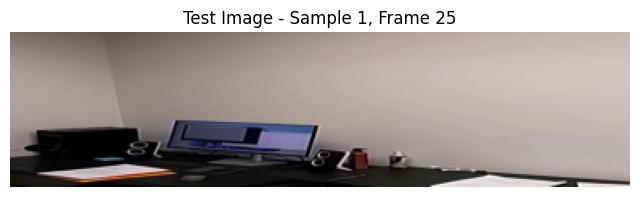

Generating response...
Input tokens: 465 (image tokens: 405)

=== MODEL RESPONSE ===
Sample: 1, Frame: 25
Video ID: T48
Response: A computer monitor is on a desk.


In [25]:
# Get image token ID for token counting
image_token_id = smol_processor.tokenizer.additional_special_tokens_ids[
    smol_processor.tokenizer.additional_special_tokens.index("<image>")]

# Select a sample and frame from the dataset
test_sample_idx = 1
test_frame_idx = 5

# Get the sample and extract an image
test_sample = dataset[test_sample_idx]
test_images = test_sample.get('images', [])

if len(test_images) > test_frame_idx:
    # Convert tensor image to PIL (same as streamprocessor)
    pt_img = test_images[test_frame_idx : test_frame_idx + 1]
    pil_img = tensor_to_pil_images(pt_img)[0]
    pil_img = pil_img.resize((384, 384 // 4))

    test_frame_idx += 10
    pt_img = test_images[test_frame_idx : test_frame_idx + 1]
    pil_img2 = tensor_to_pil_images(pt_img)[0]
    
    test_frame_idx += 10
    pt_img = test_images[test_frame_idx : test_frame_idx + 1]
    pil_img3 = tensor_to_pil_images(pt_img)[0]

    print(f"Original image size: {pil_img.size}")

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(pil_img)
    plt.title(f'Test Image - Sample {test_sample_idx}, Frame {test_frame_idx}')
    plt.axis('off')
    plt.show()
    
    # Create message format for SmolVLM
    test_messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Describe this image."},
                {"type": "image", "image": pil_img},
            ]
        },
    ]
    
    # Generate response using the same method as the runner
    print("Generating response...")

    inputs = smol_processor.apply_chat_template(
        test_messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(smol_model.device, dtype=torch.bfloat16)
    
    # Count tokens including images
    input_token_count = inputs["input_ids"].shape[-1]
    image_token_count = (inputs["input_ids"] == image_token_id).sum().item()
    
    print(f"Input tokens: {input_token_count} (image tokens: {image_token_count})")
    
    with torch.inference_mode():
        generation = smol_model.generate(
            **inputs,
            do_sample=False,
            max_new_tokens=64
        )
    
    input_len = inputs["input_ids"].shape[-1]
    response = smol_processor.decode(generation[0][input_len:], skip_special_tokens=True)
    
    print(f"\n=== MODEL RESPONSE ===")
    print(f"Sample: {test_sample_idx}, Frame: {test_frame_idx}")
    print(f"Video ID: {test_sample.get('video_uid', 'N/A')}")
    print(f"Response: {response.strip()}")
    
else:
    print(f"No images available in sample {test_sample_idx} or frame {test_frame_idx} doesn't exist")
    print(f"Available samples: {len(dataset)}")
    if test_sample_idx < len(dataset):
        print(f"Images in sample {test_sample_idx}: {len(test_sample.get('images', []))}")

## Run Streaming Inference

In [26]:
# Create the streaming runner
runner = SmolVLMStreamRunner(
    model=smol_model,
    processor=smol_processor,
    fps=2,
    max_context_tokens=14000,  # Reduced for 16k context window
    use_4_1_aspect_ratio=True   # Enable optimal image encoding
)

print("SmolVLM Stream Runner initialized")
print(f"Max context tokens: {runner.max_context_tokens}")
print(f"FPS: {runner.fps}")
print(f"Using 4:1 aspect ratio: {runner.stream_processor.use_4_1_aspect_ratio}")

SmolVLM Stream Runner initialized
Max context tokens: 14000
FPS: 2
Using 4:1 aspect ratio: True


In [27]:
# Run streaming inference on a single video (ProAssist-style)
sample_idx = 3  # Choose a sample to test
video = dataset[sample_idx]

print(f"Running streaming inference on sample {sample_idx}...")
print(f"Video ID: {video.get('video_uid', 'N/A')}")
print(f"Number of frames: {len(video.get('images', []))}")

# Run inference with verbose output
results = runner.run_inference_on_video(
    video,
    verbose=True,
    max_time=60  # Limit to 60 seconds for demo
)

print(f"\n=== INFERENCE COMPLETE ===")
print(f"Total frames processed: {len(results['predictions'])}")
print(f"Metadata: {results['metadata']}")

Running streaming inference on sample 3...
Video ID: T54
Number of frames: 1375
Preprocessing stream data...

=== Frame 0 (0.5s) ===
Context tokens: 876 (image: 405)
[0.5s] REF : None
[0.5s] GEN : A kitchen counter with a scale, cup, spoon, fork, and thermometers.

=== Frame 1 (1.0s) ===
Context tokens: 1357 (image: 810)
[1.0s] REF : None
[1.0s] GEN : A scale is on a counter with a blue cup, fork, spoon, and thermometers.

=== Frame 2 (1.5s) ===
Context tokens: 1828 (image: 1215)
[1.5s] REF : None
[1.5s] GEN : A black coffee pot is on the counter.

=== Frame 3 (2.0s) ===
Context tokens: 2302 (image: 1620)
[2.0s] REF : None
[2.0s] GEN : The brand of the scale is "KAMADO".

=== Frame 4 (2.5s) ===
Context tokens: 2776 (image: 2025)
[2.5s] REF : None
[2.5s] GEN : The brand of the scale is "KAMADO".

=== Frame 5 (3.0s) ===
Context tokens: 3250 (image: 2430)
[3.0s] REF : None
[3.0s] GEN : The brand of the scale is "KAMADO".

=== Frame 6 (3.5s) ===
Context tokens: 3724 (image: 2835)
[3.5s] RE

## Analysis and Comparison

In [ ]:
# Analyze the results
def analyze_streaming_results(results):
    """Analyze and display streaming inference results."""
    predictions = results['predictions']
    metadata = results['metadata']
    
    print(f"=== STREAMING INFERENCE ANALYSIS ===")
    print(f"Model: {metadata['model_type']}")
    print(f"Total frames processed: {metadata['total_frames_processed']}")
    print(f"FPS: {metadata['fps']}")
    print(f"Max context tokens: {metadata['max_context_tokens']}")
    print(f"Using 4:1 aspect ratio: {metadata.get('use_4_1_aspect_ratio', 'N/A')}")
    
    # Count frames with responses
    frames_with_responses = sum(1 for p in predictions if p.gen.strip())
    frames_with_references = sum(1 for p in predictions if p.ref and p.ref.strip())
    
    print(f"\nFrames with generated responses: {frames_with_responses}/{len(predictions)}")
    print(f"Frames with reference responses: {frames_with_references}/{len(predictions)}")
    
    # Show context length progression
    context_lengths = [p.context_length for p in predictions if p.context_length]
    image_tokens = [p.image_tokens_used for p in predictions if p.image_tokens_used]
    
    if context_lengths:
        print(f"\nContext length progression:")
        print(f"  Initial: {context_lengths[0]}")
        print(f"  Final: {context_lengths[-1]}")
        print(f"  Max: {max(context_lengths)}")
        
    if image_tokens:
        print(f"\nImage token usage:")
        print(f"  Initial: {image_tokens[0]}")
        print(f"  Final: {image_tokens[-1]}")
        print(f"  Max: {max(image_tokens)}")
    
    # Show some example comparisons
    print(f"\n=== EXAMPLE COMPARISONS ===")
    comparison_count = 0
    for i, pred in enumerate(predictions):
        if pred.ref and pred.ref.strip() and comparison_count < 3:
            print(f"\nFrame {pred.frame_idx_in_stream} ({pred.timestamp_in_stream:.1f}s):")
            print(f"  Context: {pred.context_length} tokens ({pred.image_tokens_used} image)")
            print(f"  REF: {pred.ref}")
            print(f"  GEN: {pred.gen}")
            comparison_count += 1

# Analyze the results
analyze_streaming_results(results)

## Test Multiple Samples

In [ ]:
# Test on multiple samples to see consistency
def test_multiple_samples(runner, dataset, sample_indices=[1, 2, 3], max_time=30):
    """Test streaming inference on multiple samples."""
    all_results = []
    
    for idx in sample_indices:
        print(f"\n{'='*50}")
        print(f"TESTING SAMPLE {idx}")
        print(f"{'='*50}")
        
        video = dataset[idx]
        print(f"Video ID: {video.get('video_uid', 'N/A')}")
        print(f"Number of frames: {len(video.get('images', []))}")
        
        try:
            # Reset runner state
            runner.conversation_history = []
            runner.frame_history = []
            
            results = runner.run_inference_on_video(
                video,
                verbose=False,  # Set to True for detailed output
                max_time=max_time
            )
            
            all_results.append((idx, results))
            
            # Quick summary
            predictions = results['predictions']
            frames_with_gen = sum(1 for p in predictions if p.gen.strip())
            frames_with_ref = sum(1 for p in predictions if p.ref and p.ref.strip())
            
            # Context statistics
            context_lengths = [p.context_length for p in predictions if p.context_length]
            image_tokens = [p.image_tokens_used for p in predictions if p.image_tokens_used]
            
            print(f"Processed {len(predictions)} frames")
            print(f"Generated responses: {frames_with_gen}")
            print(f"Reference responses: {frames_with_ref}")
            if context_lengths:
                print(f"Max context tokens: {max(context_lengths)}")
            if image_tokens:
                print(f"Max image tokens: {max(image_tokens)}")
            
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            import traceback
            traceback.print_exc()
    
    return all_results

# Test multiple samples
multi_results = test_multiple_samples(runner, dataset, sample_indices=[1, 2, 3], max_time=30)

## Compare 4:1 vs Original Aspect Ratio

In [ ]:
# Compare performance with and without 4:1 aspect ratio optimization
print("Comparing 4:1 aspect ratio vs original aspect ratio...")

# Test with original aspect ratio
runner_original = SmolVLMStreamRunner(
    model=smol_model,
    processor=smol_processor,
    fps=2,
    max_context_tokens=14000,
    use_4_1_aspect_ratio=False  # Disable 4:1 optimization
)

# Test with 4:1 aspect ratio
runner_4_1 = SmolVLMStreamRunner(
    model=smol_model,
    processor=smol_processor,
    fps=2,
    max_context_tokens=14000,
    use_4_1_aspect_ratio=True   # Enable 4:1 optimization
)

test_video = dataset[1]

print("\n=== Testing Original Aspect Ratio ===")
try:
    results_original = runner_original.run_inference_on_video(
        test_video, verbose=False, max_time=20
    )
    
    # Get image token stats
    image_tokens_orig = [p.image_tokens_used for p in results_original['predictions'] if p.image_tokens_used]
    context_tokens_orig = [p.context_length for p in results_original['predictions'] if p.context_length]
    
    print(f"Frames processed: {len(results_original['predictions'])}")
    if image_tokens_orig:
        print(f"Image tokens - Min: {min(image_tokens_orig)}, Max: {max(image_tokens_orig)}, Avg: {sum(image_tokens_orig)/len(image_tokens_orig):.1f}")
    if context_tokens_orig:
        print(f"Context tokens - Min: {min(context_tokens_orig)}, Max: {max(context_tokens_orig)}")
        
except Exception as e:
    print(f"Error with original aspect ratio: {e}")

print("\n=== Testing 4:1 Aspect Ratio ===")
try:
    results_4_1 = runner_4_1.run_inference_on_video(
        test_video, verbose=False, max_time=20
    )
    
    # Get image token stats
    image_tokens_4_1 = [p.image_tokens_used for p in results_4_1['predictions'] if p.image_tokens_used]
    context_tokens_4_1 = [p.context_length for p in results_4_1['predictions'] if p.context_length]
    
    print(f"Frames processed: {len(results_4_1['predictions'])}")
    if image_tokens_4_1:
        print(f"Image tokens - Min: {min(image_tokens_4_1)}, Max: {max(image_tokens_4_1)}, Avg: {sum(image_tokens_4_1)/len(image_tokens_4_1):.1f}")
    if context_tokens_4_1:
        print(f"Context tokens - Min: {min(context_tokens_4_1)}, Max: {max(context_tokens_4_1)}")
        
except Exception as e:
    print(f"Error with 4:1 aspect ratio: {e}")

print("\n=== Comparison Summary ===")
print("4:1 aspect ratio optimization can help reduce image token usage and improve context efficiency.")

## Summary

This notebook implements Version 1 of SmolVLM streaming inference that mimics ProAssist behavior:

### Key Features Implemented:
1. **ProAssist-Style Forced Generation**: Model generates responses at every frame where there should be an assistant turn
2. **External Context Management**: Uses string-based context tracking with adaptive image token counting
3. **Automatic Summarization**: When context exceeds 14K tokens, uses SmolVLM to summarize and reset context
4. **Adaptive Image Token Counting**: Accounts for variable image token sizes based on actual processing
5. **4:1 Aspect Ratio Optimization**: Optional image resizing for optimal SmolVLM encoding efficiency
6. **Format Conversion**: Converts ProAssist dataset format to SmolVLM's chat template format
7. **Verbose Output**: Prints processed contexts and compares generated vs reference responses

### Differences from Gemma 3N Version:
- Uses SmolVLM-Instruct model instead of Gemma 3N
- Reduced context window (14K vs 30K tokens) due to SmolVLM's 16K limit
- Adaptive image token counting instead of fixed tokens per image
- Optional 4:1 aspect ratio resizing for optimal encoding
- Uses SmolVLM's generation parameters (do_sample=False)

### Key Optimizations:
- **Smart Token Counting**: Real-time counting of both text and image tokens
- **Context Efficiency**: 4:1 aspect ratio can reduce image token usage
- **Memory Management**: Proper context reset with summarization

### Next Steps:
- Implement Version 2 (True Streaming with decision-making)
- Compare performance between SmolVLM and Gemma 3N versions
- Optimize context summarization strategies for the smaller context window
- Evaluate the impact of 4:1 aspect ratio optimization on model performance